# MPI calibration of a Grid5000 cluster

## Data exploration

In [1]:
import os
import zipfile
import yaml
import pandas
import io

archive_name = 'grenoble_2018-08-29_1808878.zip'

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'))['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name))
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

threshold = 8133

# I really hate that we have to define these two values:
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

result = extract_zip(archive_name)

In [2]:
!unzip -p $archive_name info.yaml

cluster: dahu
command: /home/tocornebize/.local/bin/peanut MPICalibration run tocornebize --jobid
  grenoble:1808878 --deploy debian9-x64-base --expfile exp.csv
dahu-11.grenoble.grid5000.fr:
  arp:
    dahu-15.grenoble.grid5000.fr:
    - (172.16.20.15) at 3c:fd:fe:55:ed:60 [ether] on enp24s0f0
    dns.grenoble.grid5000.fr:
    - (172.16.31.110) at 00:16:3e:4f:65:bf [ether] on enp24s0f0
    fgrenoble.grenoble.grid5000.fr:
    - (172.16.31.101) at 00:16:3e:06:dd:61 [ether] on enp24s0f0
    gw.grenoble.grid5000.fr:
    - (172.16.31.254) at 00:04:96:1d:09:40 [ether] on enp24s0f0
    kadeploy.grenoble.grid5000.fr:
    - (172.16.31.102) at 00:16:3e:c8:38:51 [ether] on enp24s0f0
  cpu: Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
  gcc: 6.3.0
  kernel: 4.9.0-7-amd64
  mpi: mpirun (Open MPI) 2.0.2
  version: 'Linux version 4.9.0-7-amd64 (debian-kernel@lists.debian.org) (gcc version
    6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u1 (2018-08-03)'
dahu-15.grenoble.grid5000.

In [3]:
# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']
df_wtime = result['exp/exp_Wtime.csv']
df_test = result['exp/exp_Test.csv']
df_iprobe = result['exp/exp_Iprobe.csv']

# STAN

In [4]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
import pystan
import numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    real<lower=0> duration[N];
    real<lower=0> msg_size[N];
    int<lower=1> nb_modes;
    int<lower = 0, upper = 1> run_estimation; // a switch to evaluate the likelihood, see http://modernstatisticalworkflow.blogspot.com/2017/04/an-easy-way-to-simulate-fake-data-from.html
    real<lower=0> sd_intercept;
    real<lower=0> sd_coefficient;
    real<lower=0> prior_sigma;
    real prior_intercept[nb_modes];
    real prior_coefficient;
}

transformed data {
    real min_size = min(msg_size);
    real max_size = max(msg_size);
}

parameters {
    ordered[nb_modes] intercept;
    real coefficient;
    real<lower=0> sigma[nb_modes];
    simplex[nb_modes] theta;
}

model {
    // Priors
    for (i in 1:nb_modes) {
        intercept[i] ~ normal(prior_intercept[i], sd_intercept);
    }
    coefficient ~ normal(prior_coefficient, sd_coefficient);
    sigma ~ normal(prior_sigma, prior_sigma);
    theta ~ dirichlet(rep_vector(1, nb_modes));
    
    // Likelihood
    if(run_estimation==1) {
        for (i in 1:N) {
            vector[nb_modes] contributions;
            for(k in 1:nb_modes) {
                contributions[k] = log(theta[k]) + normal_lpdf(duration[i] | intercept[k] + coefficient*msg_size[i], sigma[k]);
            }
            target += log_sum_exp(contributions);
        }
    }
}

generated quantities {
    real duration_sim;
    int mode;
    real size_sim;
    mode = categorical_rng(theta);
    size_sim = msg_size[categorical_rng(rep_vector(1,N) / N)];
    duration_sim = normal_rng(intercept[mode] + coefficient*size_sim, sigma[mode]);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ea2e1b5fd1c6ab6f0e38f507018fa23 NOW.


CPU times: user 1.08 s, sys: 47.1 ms, total: 1.13 s
Wall time: 1min 4s


Inference for Stan model: anon_model_5ea2e1b5fd1c6ab6f0e38f507018fa23.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept[1]10.0e-7  4.5e-810.0e-8 7.7e-7 9.7e-7 1.0e-6 1.1e-6 1.1e-6      5   4.25
intercept[2] 2.2e-6  4.5e-810.0e-8 2.0e-6 2.2e-6 2.2e-6 2.3e-6 2.3e-6      5   4.25
intercept[3] 6.0e-6  4.5e-810.0e-8 5.8e-6 6.0e-6 6.0e-6 6.1e-6 6.1e-6      5   4.25
coefficient 8.5e-11 1.7e-138.2e-126.8e-117.9e-118.5e-119.0e-111.0e-10   2269    1.0
sigma[1]    10.0e-8 3.6e-157.7e-1510.0e-810.0e-810.0e-8 1.0e-7 1.0e-7      5   4.17
sigma[2]     1.0e-7 3.4e-157.9e-1510.0e-8 1.0e-7 1.0e-7 1.0e-7 1.0e-7      5   3.86
sigma[3]     1.0e-6 3.8e-148.0e-1410.0e-710.0e-7 1.0e-6 1.0e-6 1.0e-6      4   4.61
theta[1]       0.49  7.2e-9 1.7e-8   0.49   0.49   0.49   0.49   0.49      6   3.55
theta[2]       0.49  7.0e-9 1.7e-8   0.49   0.49   0.49   

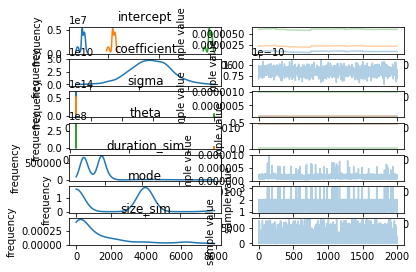

In [6]:
%%time

nb_modes = 3
prior_intercept = [1e-6, 2.2e-6, 6e-6]
prior_coefficient = 8.456e-11
prior_sigma = [1e-7, 1e-7, 1e-6]

def mean(l):
    return sum(l)/len(l)

def initfunction():
    return {
        'intercept': prior_intercept,
        'coefficient': prior_coefficient,
        'sigma': prior_sigma,
        'theta': [0.49, 0.49, 0.02]
    }


df = df_recv[df_recv.msg_size < 8133].sample(n=10000) # taking only a (random) subset of the data
data=dict(N=len(df), duration=df.duration, msg_size=df.msg_size, nb_modes=nb_modes, run_estimation=0,
          sd_intercept=mean(prior_intercept)/10, sd_coefficient=prior_coefficient/10, prior_sigma=mean(prior_sigma),
          prior_intercept = prior_intercept, prior_coefficient=prior_coefficient)

fit = sm.sampling(data=data, iter=500, chains=8, init=initfunction)
print(fit)

fit.plot()

In [7]:
def plot_posterior(df, fit):
    generated_df = fit.to_dataframe()
    generated_df['mode'] = generated_df['mode'].astype(int)
    plot = ggplot() + geom_point(generated_df, aes(x='size_sim', y='duration_sim', color='factor(mode)'))
    plot = plot + geom_point(df, aes(x='msg_size', y='duration'), alpha=0.1)
    plot = plot + theme_bw() + scale_x_log10() + scale_y_log10()
    return plot

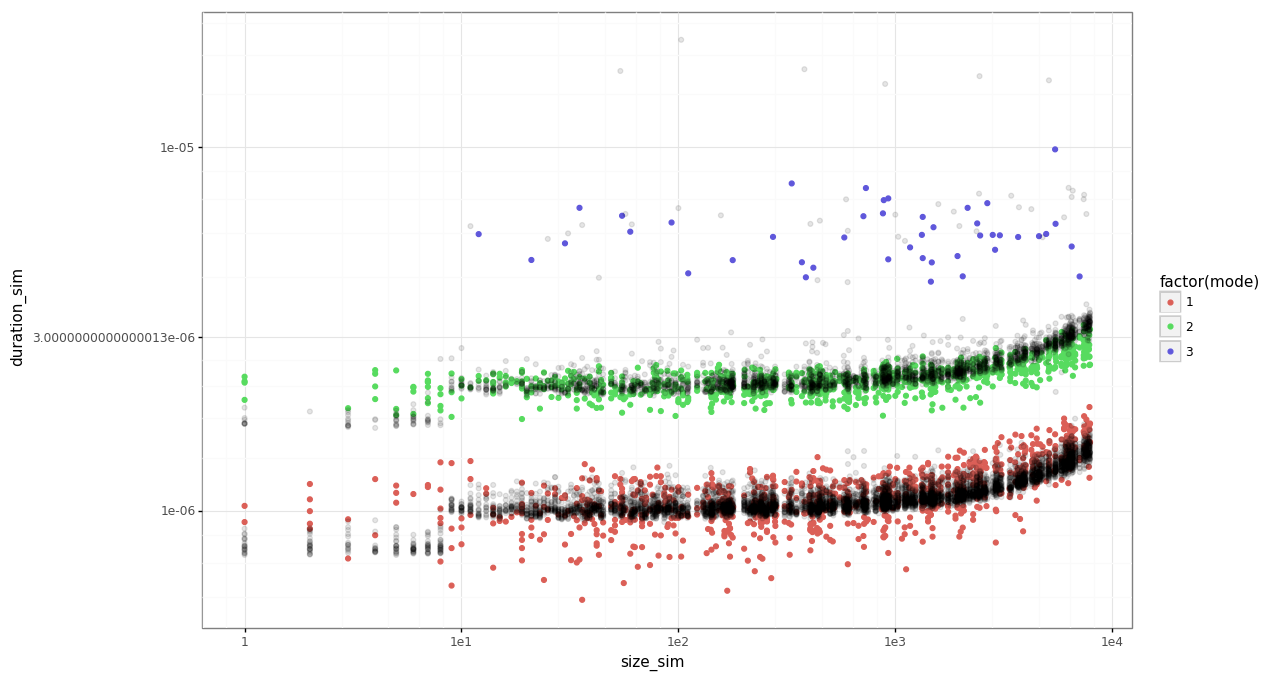

<ggplot: (-9223363305664049464)>

In [8]:
plot_posterior(df, fit)

Inference for Stan model: anon_model_5ea2e1b5fd1c6ab6f0e38f507018fa23.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept[1] 1.0e-6 2.4e-10 1.2e-9 1.0e-6 1.0e-6 1.0e-6 1.0e-6 1.0e-6     23   1.47
intercept[2] 2.2e-6 2.4e-10 1.2e-9 2.2e-6 2.2e-6 2.2e-6 2.2e-6 2.2e-6     23   1.47
intercept[3] 6.0e-6 2.4e-10 1.2e-9 6.0e-6 6.0e-6 6.0e-6 6.0e-6 6.0e-6     23   1.47
coefficient 7.5e-11 6.2e-145.3e-137.4e-117.5e-117.5e-117.6e-117.7e-11     75   1.11
sigma[1]     1.0e-7 1.1e-163.0e-16 1.0e-7 1.0e-7 1.0e-7 1.0e-7 1.0e-7      7   2.58
sigma[2]     1.0e-7 2.3e-165.0e-16 1.0e-7 1.0e-7 1.0e-7 1.0e-7 1.0e-7      5   4.83
sigma[3]     1.0e-6 2.0e-154.5e-15 1.0e-6 1.0e-6 1.0e-6 1.0e-6 1.0e-6      5   3.82
theta[1]       0.49 5.2e-10 1.1e-9   0.49   0.49   0.49   0.49   0.49      5   3.83
theta[2]       0.49 5.1e-10 1.1e-9   0.49   0.49   0.49   

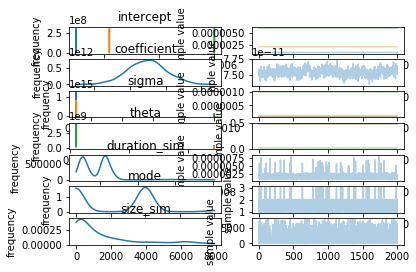

In [9]:
%%time

data['run_estimation'] = 1
fit = sm.sampling(data=data, iter=500, chains=8, init=initfunction)
print(fit)
fit.plot()

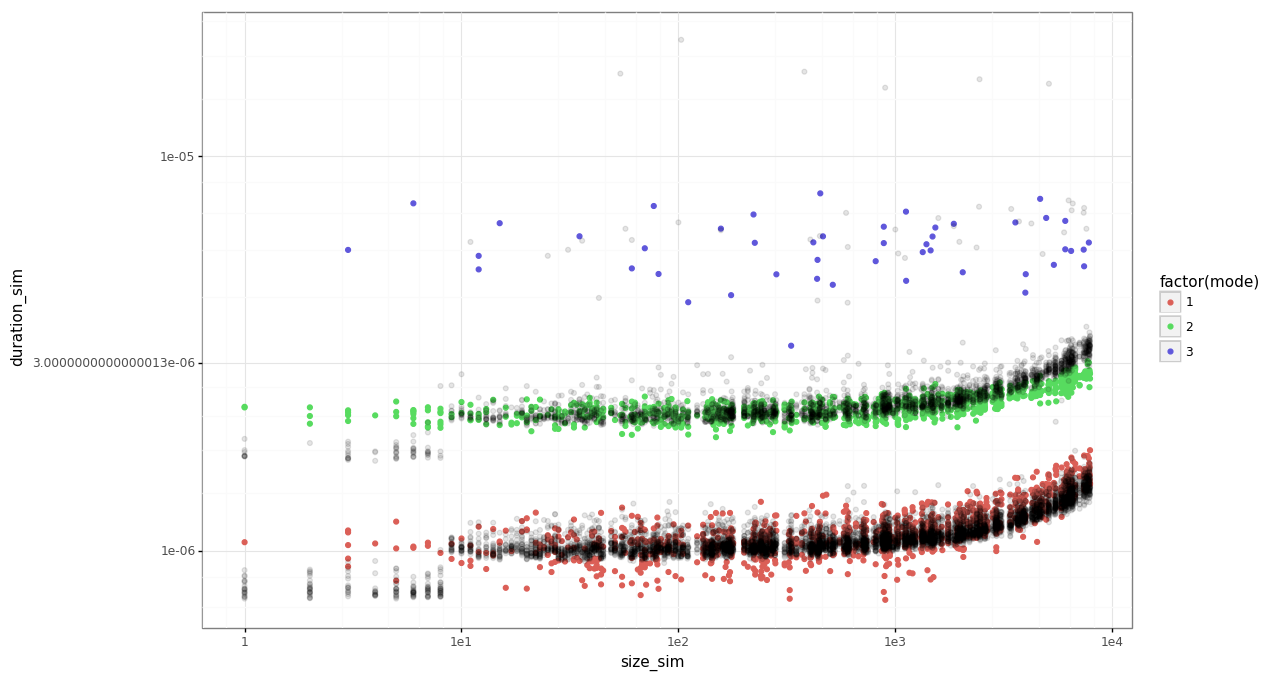

<ggplot: (8731228213596)>

In [10]:
plot_posterior(df, fit)